In [2]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('data/diabetic_data.csv')

# Display the first 5 rows
print("First 5 rows of the dataset:")
display(df.head())

# Get a concise summary of the dataframe
print("\nDataset Info:")
df.info()

# Check the dimensions of the dataset
print(f"\nDataset shape: {df.shape}")

First 5 rows of the dataset:


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  i

In [3]:
# Replace '?' with NaN (Not a Number)
df.replace('?', np.nan, inplace=True)

# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().sum() * 100 / len(df)
print("Percentage of missing values in each column:")
print(missing_percentage.sort_values(ascending=False))

# Drop columns with a high percentage of missing values (e.g., > 40%)
# 'weight', 'medical_specialty', and 'payer_code' are common candidates
df.drop(['weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True)

print("\nShape of dataframe after dropping sparse columns:", df.shape)

Percentage of missing values in each column:
weight                      96.858479
max_glu_serum               94.746772
A1Cresult                   83.277322
medical_specialty           49.082208
payer_code                  39.557416
race                         2.233555
diag_3                       1.398306
diag_2                       0.351787
diag_1                       0.020636
patient_nbr                  0.000000
time_in_hospital             0.000000
admission_source_id          0.000000
num_lab_procedures           0.000000
encounter_id                 0.000000
admission_type_id            0.000000
discharge_disposition_id     0.000000
gender                       0.000000
age                          0.000000
number_inpatient             0.000000
number_emergency             0.000000
number_outpatient            0.000000
num_medications              0.000000
num_procedures               0.000000
number_diagnoses             0.000000
metformin                    0.000000
repag

In [4]:
# Let's inspect the 'readmitted' column
print("Original value counts for 'readmitted':")
print(df['readmitted'].value_counts())

# Map the values to a binary outcome
# '<30' means the patient was readmitted within 30 days (our positive class, 1)
# '>30' and 'NO' mean the patient was not readmitted within 30 days (our negative class, 0)
df['readmitted'] = df['readmitted'].replace({'<30': 1, '>30': 0, 'NO': 0})

# Verify the changes
print("\nNew value counts for 'readmitted':")
print(df['readmitted'].value_counts())

# Notice the class imbalance: far more 0s than 1s. We will handle this later.

Original value counts for 'readmitted':
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

New value counts for 'readmitted':
readmitted
0    90409
1    11357
Name: count, dtype: int64


C:\Users\Brenda\AppData\Local\Temp\ipykernel_12004\1635786015.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['readmitted'] = df['readmitted'].replace({'<30': 1, '>30': 0, 'NO': 0})


In [5]:
print(f"Shape before dropping duplicates: {df.shape}")

# The 'patient_nbr' column identifies unique patients
df.drop_duplicates(subset=['patient_nbr'], keep='first', inplace=True)

print(f"Shape after dropping duplicates: {df.shape}")

Shape before dropping duplicates: (101766, 47)
Shape after dropping duplicates: (71518, 47)


In [6]:
# Drop encounter_id and patient_nbr as they are just identifiers and not useful features for prediction
df.drop(['encounter_id', 'patient_nbr'], axis=1, inplace=True)

# The 'diag' columns have thousands of unique codes (ICD-9).
# A simple feature engineering approach is to group them by broader categories.
# For now, let's just check for missing values in them (which might be represented by NaN after our earlier step)
# A common strategy for the few remaining NaNs is to fill with the mode (most frequent value).
for col in ['race', 'diag_1', 'diag_2', 'diag_3']:
    if df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)

# Let's check if 'gender' has any non-binary values that need cleaning
print("\nValue counts for 'gender':")
print(df['gender'].value_counts())

# There's a small number of 'Unknown/Invalid' values. Let's remove these rows.
df = df[df['gender'] != 'Unknown/Invalid']
print("\nShape after removing 'Unknown/Invalid' gender:", df.shape)


Value counts for 'gender':
gender
Female             38025
Male               33490
Unknown/Invalid        3
Name: count, dtype: int64

Shape after removing 'Unknown/Invalid' gender: (71515, 45)


C:\Users\Brenda\AppData\Local\Temp\ipykernel_12004\1004529840.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [7]:
# Grouping diagnosis codes into broader categories
# Based on ICD-9 code ranges

def map_diag_codes(df_col):
    # Neoplasms
    if df_col.startswith('1') and 140 <= float(df_col) < 240: return 'Neoplasms'
    # Diabetes
    if df_col.startswith('250'): return 'Diabetes'
    # Circulatory
    if (df_col.startswith('39') and 390 <= float(df_col) < 460) or (df_col.startswith('785')): return 'Circulatory'
    # Respiratory
    if (df_col.startswith('4') and 460 <= float(df_col) < 520) or (df_col.startswith('786')): return 'Respiratory'
    # Digestive
    if (df_col.startswith('5') and 520 <= float(df_col) < 580) or (df_col.startswith('787')): return 'Digestive'
    # Genitourinary
    if (df_col.startswith('58') and 580 <= float(df_col) < 630) or (df_col.startswith('788')): return 'Genitourinary'
    # Musculoskeletal
    if df_col.startswith('710') or (df_col.startswith('7') and 710 <= float(df_col) < 740): return 'Musculoskeletal'
    # Injury
    if df_col.startswith('8') or df_col.startswith('9'): return 'Injury'
    # Other
    return 'Other'

# Apply the mapping function to the diagnosis columns
# We must first ensure the columns are strings
df['diag_1'] = df['diag_1'].astype(str).apply(map_diag_codes)
df['diag_2'] = df['diag_2'].astype(str).apply(map_diag_codes)
df['diag_3'] = df['diag_3'].astype(str).apply(map_diag_codes)

# Let's check the new value counts
print("Value counts for diag_1 after grouping:")
print(df['diag_1'].value_counts())

Value counts for diag_1 after grouping:
diag_1
Other              38296
Respiratory         8349
Digestive           6570
Diabetes            5805
Injury              5107
Musculoskeletal     4080
Neoplasms           2057
Genitourinary       1070
Circulatory          181
Name: count, dtype: int64


In [8]:
# List of medication columns
med_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'
]

# Create a feature for the number of medications prescribed
# 'No' means not prescribed. Any other value ('Up', 'Down', 'Steady') means it is.
df['num_medications'] = (df[med_cols] != 'No').sum(axis=1)

print("Description of the new 'num_medications' feature:")
print(df['num_medications'].describe())

Description of the new 'num_medications' feature:
count    71515.000000
mean         1.182703
std          0.940275
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: num_medications, dtype: float64


In [9]:
# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=np.number).columns

print(f"Categorical columns to be encoded: {list(categorical_cols)}")

# Perform one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("\nShape of dataframe after one-hot encoding:", df_encoded.shape)
print("A few of the new columns:", list(df_encoded.columns[-5:]))

Categorical columns to be encoded: ['race', 'gender', 'age', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']

Shape of dataframe after one-hot encoding: (71515, 101)
A few of the new columns: ['glipizide-metformin_Steady', 'metformin-rosiglitazone_Steady', 'metformin-pioglitazone_Steady', 'change_No', 'diabetesMed_Yes']


In [10]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df_encoded.drop('readmitted', axis=1)
y = df_encoded['readmitted']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"\nReadmission rate in training set:\n{y_train.value_counts(normalize=True)}")
print(f"\nReadmission rate in testing set:\n{y_test.value_counts(normalize=True)}")

Training set shape: (57212, 100)
Testing set shape: (14303, 100)

Readmission rate in training set:
readmitted
0    0.912011
1    0.087989
Name: proportion, dtype: float64

Readmission rate in testing set:
readmitted
0    0.911977
1    0.088023
Name: proportion, dtype: float64


In [11]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# IMPORTANT: Apply SMOTE only to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Value counts before SMOTE:")
print(y_train.value_counts())
print("\nValue counts after SMOTE:")
print(y_train_smote.value_counts())

Value counts before SMOTE:
readmitted
0    52178
1     5034
Name: count, dtype: int64

Value counts after SMOTE:
readmitted
1    52178
0    52178
Name: count, dtype: int64


In [12]:
from sklearn.preprocessing import StandardScaler

# We need to scale only the original numerical columns
# The one-hot encoded columns are already on a 0/1 scale
cols_to_scale = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'number_outpatient', 'number_emergency', 'number_inpatient',
    'number_diagnoses', 'num_medications'
]

scaler = StandardScaler()

# Fit the scaler ONLY on the training data
X_train_smote[cols_to_scale] = scaler.fit_transform(X_train_smote[cols_to_scale])

# Transform the test data using the SAME scaler fitted on the training data
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print("\nFirst 5 rows of scaled training data:")
display(X_train_smote[cols_to_scale].head())


First 5 rows of scaled training data:


,time_in_hospital,num_lab_procedures,num_procedures,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_medications
0,0.572186,0.469472,-0.767333,-0.234348,-0.182694,-0.281371,0.892367,-0.062106
1,0.914559,-0.240866,-0.168093,-0.234348,-0.182694,-0.281371,0.892367,-0.062106
2,-0.112562,0.367996,-0.767333,-0.234348,6.623867,1.300842,0.892367,-0.062106
3,-0.112562,-0.291604,-0.168093,-0.234348,-0.182694,-0.281371,-1.196279,-0.062106
4,1.599307,-1.458588,-0.168093,-0.234348,-0.182694,-0.281371,0.892367,1.094199


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Initialize the models
# We use class_weight='balanced' for models that support it as an extra measure
log_reg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
rand_forest = RandomForestClassifier(random_state=42, class_weight='balanced')
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the models on the SMOTE-resampled training data
print("Training Logistic Regression...")
log_reg.fit(X_train_smote, y_train_smote)
print("Done.")

print("\nTraining Random Forest...")
rand_forest.fit(X_train_smote, y_train_smote)
print("Done.")

print("\nTraining XGBoost...")
xgb.fit(X_train_smote, y_train_smote)
print("Done.")

Training Logistic Regression...
Done.

Training Random Forest...
Done.

Training XGBoost...


ValueError: feature_names must be string, and may not contain [, ] or <

In [14]:
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# --- FIX STARTS HERE ---
# The error is from special characters XGBoost can't handle. Let's clean them.
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

# Clean the column names for the training set
X_train_smote.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_smote.columns.values]

# IMPORTANT: Apply the exact same column name changes to the test set
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]
# --- FIX ENDS HERE ---


# Initialize the models
log_reg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
rand_forest = RandomForestClassifier(random_state=42, class_weight='balanced')
# Note: use_label_encoder=False is deprecated and will be removed.
# We set it explicitly to avoid a warning. eval_metric silences another warning.
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')


# Train the models on the SMOTE-resampled training data
print("Training Logistic Regression...")
log_reg.fit(X_train_smote, y_train_smote)
print("Done.")

print("\nTraining Random Forest...")
rand_forest.fit(X_train_smote, y_train_smote)
print("Done.")

print("\nTraining XGBoost...")
xgb.fit(X_train_smote, y_train_smote)
print("Done.")

Training Logistic Regression...
Done.

Training Random Forest...
Done.

Training XGBoost...


C:\Users\Brenda\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:41:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Done.


Matplotlib is building the font cache; this may take a moment.


--- Evaluation for Logistic Regression ---
Classification Report:
                    precision    recall  f1-score   support

Not Readmitted (0)       0.91      0.99      0.95     13044
    Readmitted (1)       0.10      0.02      0.03      1259

          accuracy                           0.90     14303
         macro avg       0.51      0.50      0.49     14303
      weighted avg       0.84      0.90      0.87     14303

AUC-ROC Score: 0.6117



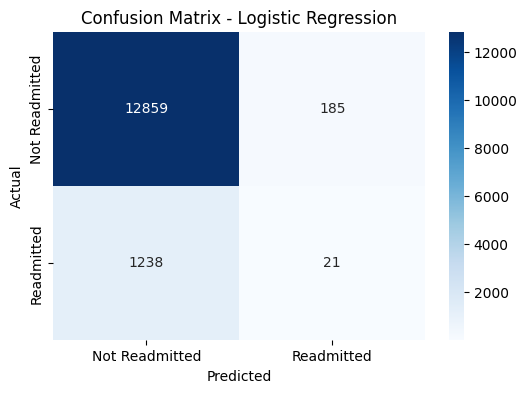

--- Evaluation for Random Forest ---
Classification Report:
                    precision    recall  f1-score   support

Not Readmitted (0)       0.91      1.00      0.95     13044
    Readmitted (1)       0.12      0.00      0.01      1259

          accuracy                           0.91     14303
         macro avg       0.52      0.50      0.48     14303
      weighted avg       0.84      0.91      0.87     14303

AUC-ROC Score: 0.5742



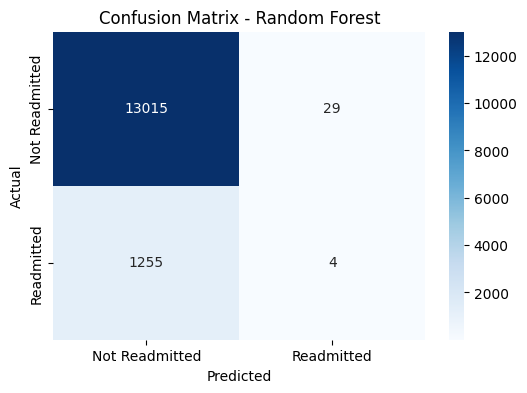

--- Evaluation for XGBoost ---
Classification Report:
                    precision    recall  f1-score   support

Not Readmitted (0)       0.91      0.99      0.95     13044
    Readmitted (1)       0.17      0.03      0.05      1259

          accuracy                           0.90     14303
         macro avg       0.54      0.51      0.50     14303
      weighted avg       0.85      0.90      0.87     14303

AUC-ROC Score: 0.6185



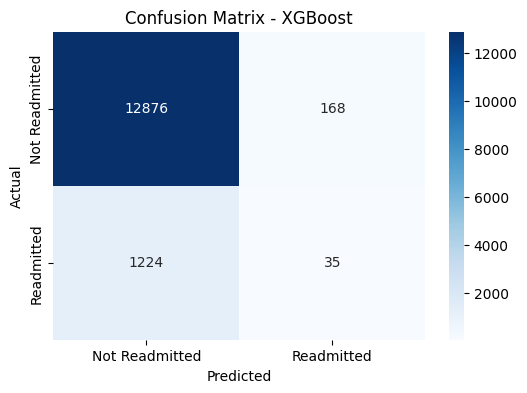

In [15]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a dictionary of our models
models = {
    "Logistic Regression": log_reg,
    "Random Forest": rand_forest,
    "XGBoost": xgb
}

# Loop through each model to make predictions and evaluate
for model_name, model in models.items():
    print(f"--- Evaluation for {model_name} ---")

    # Make predictions on the test set
    # Remember X_test has its columns cleaned from the previous step
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilities for the positive class

    # Print Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Not Readmitted (0)', 'Readmitted (1)']))

    # Print AUC Score
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC-ROC Score: {auc_score:.4f}\n")

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Readmitted', 'Readmitted'],
                yticklabels=['Not Readmitted', 'Readmitted'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

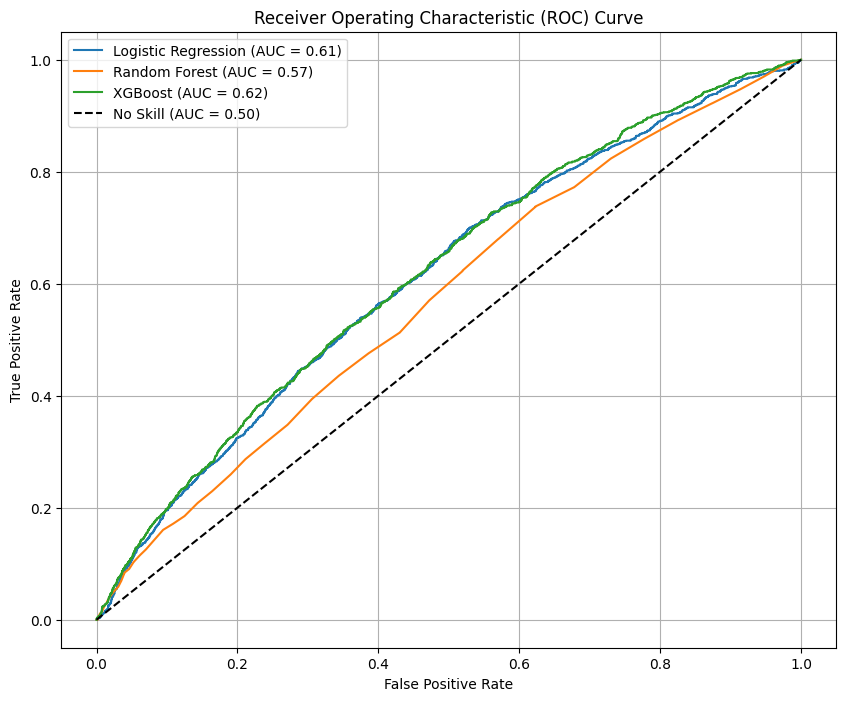

In [16]:
plt.figure(figsize=(10, 8))

# Plot the ROC curve for each model
for model_name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')

# Plot the "no-skill" line (a random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill (AUC = 0.50)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
import joblib

# The champion model
champion_model = xgb

# Also save the scaler and the columns
joblib.dump(champion_model, 'xgb_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(X_train_smote.columns, 'model_columns.joblib')

print("Model, scaler, and columns have been saved successfully.")

Model, scaler, and columns have been saved successfully.
